# Signal Denoising

We are going to look at what is noise in a signal and how to we remove it.  This section relies on our assumption that "noise" is moving very quickly, and "signal" is moving relatively slowly.

## Signal to Noise Ratio
Signal $s(t)$: True input you'd like to have in an ideal case
    - meaningful input

Noise $n(t)$: Random changes in measurement that are unrelated to previous or next time point
    - meaningless and unwanted input  
    
Observation $X = s + n$: The only input you actually get
    - signal is corrupted by noise
    
Want to measure how much signal and how much noise there is
$P$: power of some time series $X(t)$

\begin{align}
P_s &= \|s\| \\
P_n &= \|n\| \\
SNR &= \frac{P_s}{P_n}
\end{align}

If $s$ is our continuous signal
$$ \|s\|_{L^2}^2 = \int |s(t)|^2 dt $$


## SNR in decibals
Sometimes easier to measure in log scale, common uses for intensity of sound
\begin{align}
SNR_{db} = 10\cdot \log_{10}\left(\frac{P_s}{P_n} \right)
\end{align}

## Peak SNR
Instead of needing average size of signal, can instead use peak maximum of signal

\begin{align}
MSE &= \frac{1}{N} \sum_{m=0}^{N-1} (X[m] - s[m])^2 = \frac{1}{N}\|n\|^2\\
MAX_s &= \max_m |x[m]|\\
PSNR &= 10\cdot \log_{10}\left( \frac{MAX_s^2}{MSE} \right)
\end{align}

# Example of Denoising
Consider a signal of seawater rise and fall beyond mean right after an earthquake

True deviation is large and gets smaller
\begin{align}
s(t) = e^{-t^2/10} \left( \sin(2t) + 2\cos(4t) + .4\sin(t)\sin(10t) \right)
\end{align}

Don't get to see $s(t)$ directly, only sampled noisy version with ripples

Sample at rate of $100$ times a second for 10 seconds
\begin{align}
f[t] &= s[t] + .5\cdot\eta\\
\eta &\sim N(0,1)
\end{align}

$\eta$ has standard deviation 0.5

## Can we model general motion apart from noise?


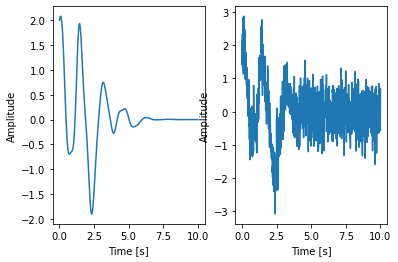

In [1]:
# Packages
import numpy as np
import matplotlib.pyplot as plt 

# Create signal
N = 1000
t = np.linspace(0, 10, N)
s = np.exp(-t**2/10)*(np.sin(2 * t) + 2.0 * np.cos(4 * t) + .4*np.sin(t)*np.sin(10*t)) 
n = .5*np.random.randn(N)
#n = 1*np.random.randn(N)

f = s + n #observations

plt.subplot(1, 2, 1)
plt.ylabel("Amplitude")
plt.xlabel("Time [s]")
plt.plot(t, s)

plt.subplot(1, 2, 2)
plt.ylabel("Amplitude")
plt.xlabel("Time [s]")
plt.plot(t, f)

plt.show()



## Compute SNR

In [3]:
# Signal noise
P_s = np.linalg.norm(s)
P_n = np.linalg.norm(n)

SNR_db = 10*np.log(P_s/P_n)

print(SNR_db)

2.6495726092658063


## Let's look at signals in frequency space

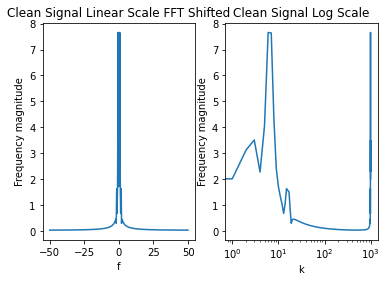

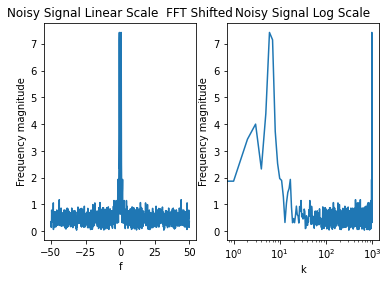

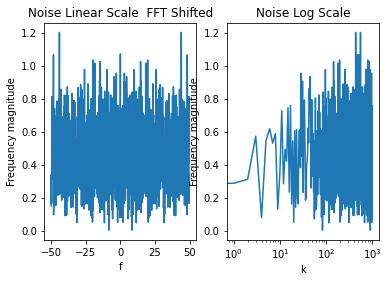

In [4]:
# Compute the FFT
s_hat = np.fft.fft(s, norm="ortho")
f_hat = np.fft.fft(f, norm="ortho")
n_hat = np.fft.fft(n, norm="ortho")

# Get some measure of frequency intervals
T = t[1] - t[0]  # sampling interval 

# 1/T = frequency
# Highest f_0 signal frequency we can represent is f_s / 2
fs_shifted = np.linspace(-1/(2*T), 1/(2*T), N)
k = np.linspace(0,N-1,N)  # f = k/(N*T)

plt.subplot(1, 2, 1)
plt.title("Clean Signal Linear Scale FFT Shifted")
plt.ylabel("Frequency magnitude")
plt.xlabel("f")
plt.plot(fs_shifted,np.abs(np.fft.fftshift(s_hat)))
#plt.plot(fs_shifted,(np.fft.fftshift(s_hat)))  # wrong way to plot because s_hat is complex
plt.subplot(1, 2, 2)
plt.title("Clean Signal Log Scale")
plt.xscale('log')
plt.ylabel("Frequency magnitude")
plt.xlabel("k")
plt.plot(k,np.abs(s_hat))
plt.show()

plt.subplot(1, 2, 1)
plt.title("Noisy Signal Linear Scale  FFT Shifted")
plt.ylabel("Frequency magnitude")
plt.xlabel("f")
plt.plot(fs_shifted,np.abs(np.fft.fftshift(f_hat)))
plt.subplot(1, 2, 2)
plt.title("Noisy Signal Log Scale")
plt.xscale('log')
plt.ylabel("Frequency magnitude")
plt.xlabel("k")
plt.plot(k,np.abs(f_hat))
plt.show()

plt.subplot(1, 2, 1)
plt.title("Noise Linear Scale  FFT Shifted")
plt.ylabel("Frequency magnitude")
plt.xlabel("f")
plt.plot(fs_shifted,np.abs(np.fft.fftshift(n_hat)))
plt.subplot(1, 2, 2)
plt.title("Noise Log Scale")
plt.xscale('log')
plt.ylabel("Frequency magnitude")
plt.xlabel("k")
plt.plot(k,np.abs(n_hat))
plt.show()

## Let's remove the high frequency noise
Maybe if we zero out the noise beyond some frequency, we'll get a better signal

Create new signal $g$ that is similar to $f$ in frequency but a little changed
\begin{align}
\widehat{g}[k] = \begin{cases} 
\widehat{f}[k] & \text{ for } k\le k_0 \text{ or } k\ge N-k_0\\
0 & \text{ else }
\end{cases}
\end{align}

Either side because
\begin{align}
\widehat{x}[k] = \overline{\widehat{x}[N-k]}
\end{align}

If you ignore the $k\ge N-k_0$ part, you will wind up with a complex number when doing IFFT.

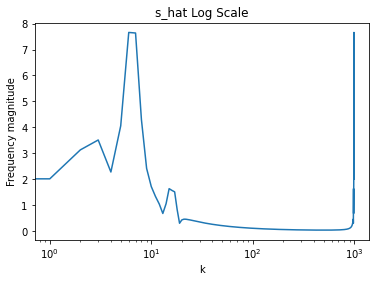

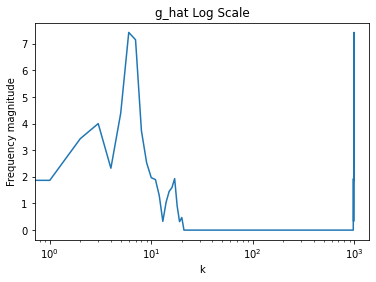

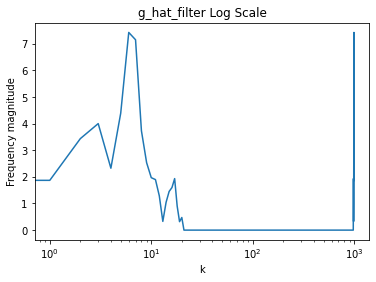

In [8]:
# Set k_0
#k_0 = 100
k_0 = 20


# Denoise
g_hat = f_hat
g_hat[k_0+1 : N-k_0] = 0


# Filter Version
h_hat = np.ones(N)
h_hat[k_0+1 : N-k_0] = 0

g_hat_filter = f_hat*h_hat

plt.title("s_hat Log Scale")
plt.xscale('log')
plt.ylabel("Frequency magnitude")
plt.xlabel("k")
plt.plot(k,np.abs(s_hat))
plt.show()

plt.title("g_hat Log Scale")
plt.xscale('log')
plt.ylabel("Frequency magnitude")
plt.xlabel("k")
plt.plot(k,np.abs(g_hat))
plt.show()

plt.title("g_hat_filter Log Scale")
plt.xscale('log')
plt.ylabel("Frequency magnitude")
plt.xlabel("k")
plt.plot(k,np.abs(g_hat_filter))
plt.show()

## So zeroing out is the same as multiplying by a rectangle function that zeros out $|f|>f_0$
## What does it look like in signal space?

Imaginary Error: 1.3683682190529354e-16
SNR: 15.223870797703716


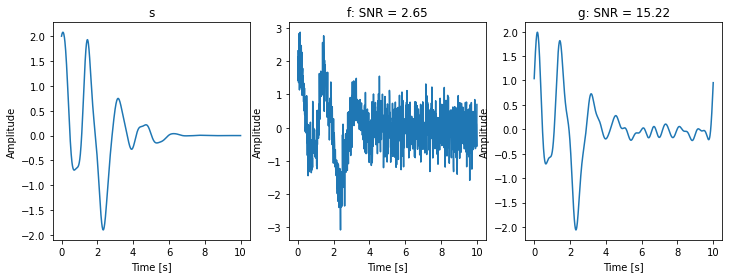

In [9]:
# Inverse DFT
g = np.fft.ifft(g_hat_filter, norm="ortho")

# Technically g now has a complex part, even though its magnitude is very small.  Can zero out
imaginary_error = np.linalg.norm(np.imag(g))/np.linalg.norm(g)
print('Imaginary Error:',imaginary_error)
g = np.real(g)

# Compute SNR
P_noisefromg = np.linalg.norm(s - g)

SNR_g = 10*np.log(P_s/P_noisefromg)

print('SNR:',SNR_g)

plt.figure(figsize=(12,4))
plt.subplot(1, 3, 1)
plt.title("s")
plt.ylabel("Amplitude")
plt.xlabel("Time [s]")
plt.plot(t, s)

plt.subplot(1, 3, 2)
plt.title("f: SNR = %2.2f" %SNR_db)
plt.ylabel("Amplitude")
plt.xlabel("Time [s]")
plt.plot(t, f)

plt.subplot(1, 3, 3)
plt.title("g: SNR = %2.2f" %SNR_g)
plt.ylabel("Amplitude")
plt.xlabel("Time [s]")
plt.plot(t, g)

plt.show()


## What does the filter look like?

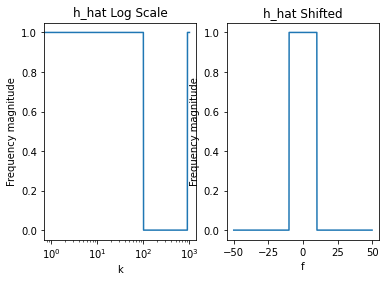

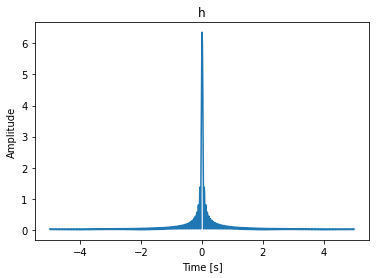

In [7]:
# Shift filter h_hat to center frequency
h_hat_shifted = np.fft.fftshift(h_hat)

# Look at filter in time space
h = np.fft.fftshift(np.fft.ifft(h_hat, norm="ortho"))

plt.subplot(1,2,1)
plt.title("h_hat Log Scale")
plt.xscale('log')
plt.ylabel("Frequency magnitude")
plt.xlabel("k")
plt.plot(k,h_hat)
plt.subplot(1,2,2)
plt.title("h_hat Shifted")
plt.ylabel("Frequency magnitude")
plt.xlabel("f")
plt.plot(fs_shifted,h_hat_shifted)
plt.show()


plt.title("h")
plt.ylabel("Amplitude")
plt.xlabel("Time [s]")
plt.plot(t-5, np.abs(h))
plt.show()



Since our filter starts before t=0 sec we need to zero pad the signal so that the two align.


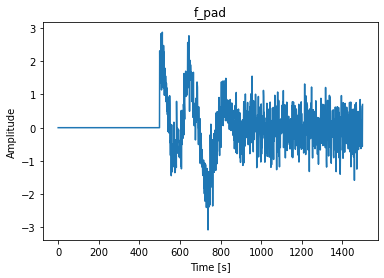

/home/v/Documents/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


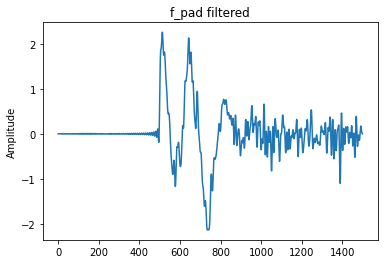

Imaginary Error: 3.9470793602394186e-17


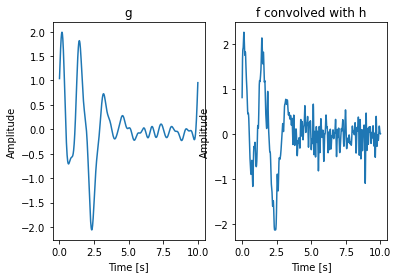

In [10]:
# let's pad the signal so it aligns with the filter
f_pad = np.concatenate((np.zeros(np.floor(N/2).astype(int)), f))

plt.title("f_pad")
plt.ylabel("Amplitude")
plt.xlabel("Time [s]")
plt.plot(f_pad)
plt.show()

# Convolve
f_conv_h = np.convolve(f_pad, h,'same')/np.sqrt(N)

plt.title("f_pad filtered")
plt.ylabel("Amplitude")
plt.plot(f_conv_h)
plt.show()


# Start it at time point 0 (recall signal is N+N/2 long total)
f_conv_h = f_conv_h[np.floor(N/2).astype(int):]

imaginary_error = np.linalg.norm(np.imag(f_conv_h))/np.linalg.norm(f_conv_h)
print('Imaginary Error:',imaginary_error)
f_conv_h = np.real(f_conv_h)


plt.subplot(1, 2, 1)
plt.title("g")
plt.ylabel("Amplitude")
plt.xlabel("Time [s]")
plt.plot(t, g)
plt.subplot(1,2,2)
plt.title("f convolved with h")
plt.ylabel("Amplitude")
plt.xlabel("Time [s]")
plt.plot(t,f_conv_h)
plt.show()

### Filtering in DFT domain

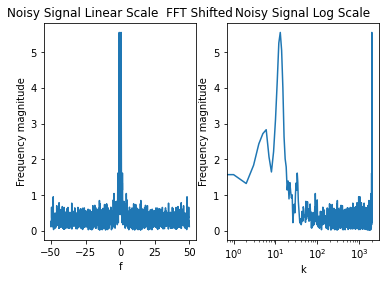

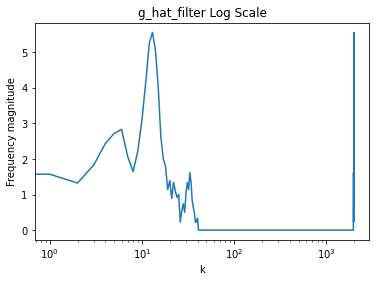

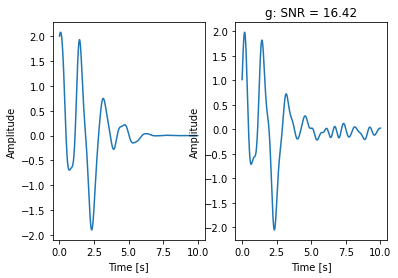

In [11]:
# Compute the FFT
length_sig = 2*N-1
f_hat = np.fft.fft(f, n=length_sig, norm="ortho")

# Get some measure of frequency intervals
T = t[1] - t[0]  # sampling interval 
N = s.size

# 1/T = frequency
fs_shifted = np.linspace(-1/(2*T), 1/(2*T), length_sig)
k = np.linspace(0,length_sig-1,length_sig)


plt.subplot(1, 2, 1)
plt.title("Noisy Signal Linear Scale  FFT Shifted")
plt.ylabel("Frequency magnitude")
plt.xlabel("f")
plt.plot(fs_shifted,np.abs(np.fft.fftshift(f_hat)))
plt.subplot(1, 2, 2)
plt.title("Noisy Signal Log Scale")
plt.xscale('log')
plt.ylabel("Frequency magnitude")
plt.xlabel("k")
plt.plot(k,np.abs(f_hat))
plt.show()


k_0 = 40
# Filter Version
h_hat = np.ones(length_sig)
h_hat[k_0+1 : length_sig-k_0] = 0
g_hat_filter = f_hat*h_hat

plt.title("g_hat_filter Log Scale")
plt.xscale('log')
plt.ylabel("Frequency magnitude")
plt.xlabel("k")
plt.plot(k,np.abs(g_hat_filter))
plt.show()



# Inverse DFT
g = np.fft.ifft(g_hat_filter, norm="ortho")
g = np.real(g)


P_noisefromg = np.linalg.norm(s - g[0:N])

SNR_g = 10*np.log(P_s/P_noisefromg)


plt.subplot(1, 2, 1)
plt.ylabel("Amplitude")
plt.xlabel("Time [s]")
plt.plot(t, s)

plt.subplot(1, 2, 2)
plt.title("g: SNR = %2.2f" %SNR_g)
plt.ylabel("Amplitude")
plt.xlabel("Time [s]")
plt.plot(t, g[0:N])

plt.show()



# Moving Average Filtering

## What if we created a smoother filter that didn't have a sharp cutoff
Let's instead create a filter in time space and see what that does to the frequencies of our signal

Note that this filter is FIR, and it's causal!
\begin{align}
y[n] = \frac{x[n] + x[n-1] + ... + x[n-n_0+1]}{n_0}
\end{align}

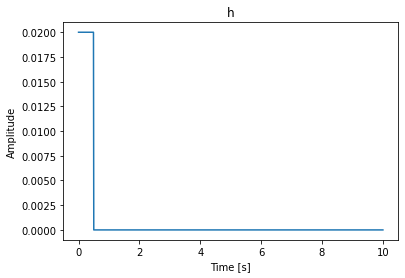

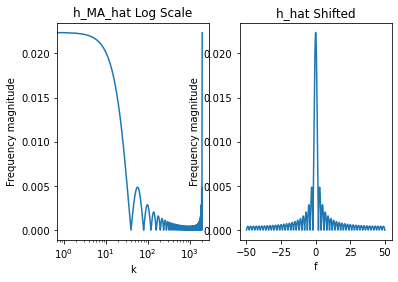

In [12]:
# Moving average filter
n_0 = 50

h_MA = np.zeros(length_sig)
h_MA[0:n_0] = 1/n_0

plt.title("h")
plt.ylabel("Amplitude")
plt.xlabel("Time [s]")
plt.plot(t, h_MA[0:N])
plt.show()

# Averaging filter in frequency space
h_MA_hat = np.fft.fft(h_MA, norm="ortho")
h_MA_hat_shifted = np.fft.fftshift(h_MA_hat)

plt.subplot(1,2,1)
plt.title("h_MA_hat Log Scale")
plt.xscale('log')
plt.ylabel("Frequency magnitude")
plt.xlabel("k")
plt.plot(k,np.abs(h_MA_hat))
plt.subplot(1,2,2)
plt.title("h_hat Shifted")
plt.ylabel("Frequency magnitude")
plt.xlabel("f")
plt.plot(fs_shifted,np.abs(h_MA_hat_shifted))
plt.show()

## What does this do in time and in frequency?

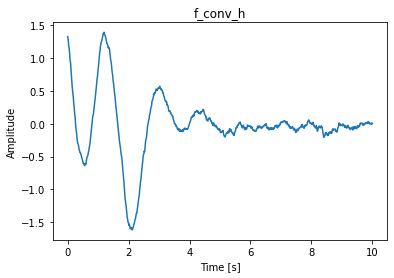

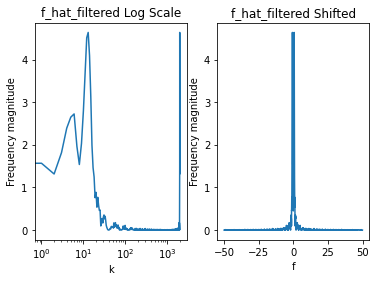

Imaginary Error: 3.5040820277999813e-16


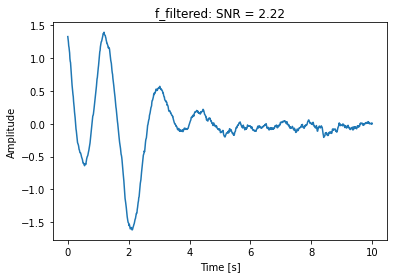

In [14]:
# In time
f_conv_h_MA = np.convolve(f, h_MA)
f_conv_h_MA = f_conv_h_MA[n_0:N+n_0]

plt.title("f_conv_h")
plt.ylabel("Amplitude")
plt.xlabel("Time [s]")
plt.plot(t,f_conv_h_MA)
plt.show()


# In frequency
f_hat = np.fft.fft(f,n=length_sig, norm="ortho")
f_hat_filtered = f_hat*h_MA_hat * np.sqrt(length_sig)
f_hat_filtered_shifted = np.fft.fftshift(f_hat_filtered)

plt.subplot(1,2,1)
plt.title("f_hat_filtered Log Scale")
plt.xscale('log')
plt.ylabel("Frequency magnitude")
plt.xlabel("k")
plt.plot(k,np.abs(f_hat_filtered))
plt.subplot(1,2,2)
plt.title("f_hat_filtered Shifted")
plt.ylabel("Frequency magnitude")
plt.xlabel("f")
plt.plot(fs_shifted,np.abs(f_hat_filtered_shifted))
plt.show()



# Back to time
f_filtered = np.fft.ifft(f_hat_filtered, norm="ortho")


imaginary_error = np.linalg.norm(np.imag(f_filtered))/np.linalg.norm(f_filtered)
print('Imaginary Error:',imaginary_error)
f_filtered = np.real(f_filtered)


P_noisefrom_MA = np.linalg.norm(s - f_filtered[n_0:N+n_0])

SNR_MA = 10*np.log(P_s/P_noisefrom_MA)


plt.title("f_filtered: SNR = %2.2f" %SNR_MA)
plt.ylabel("Amplitude")
plt.xlabel("Time [s]")
plt.plot(t, f_filtered[n_0:N+n_0])
plt.show()

# Let's try to find peaks of the frequencies, get rid of every spike that isn't large.

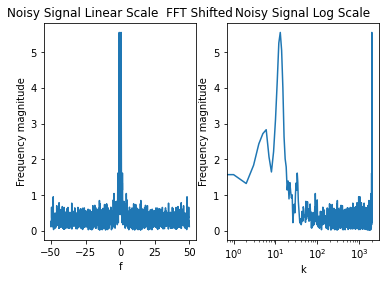

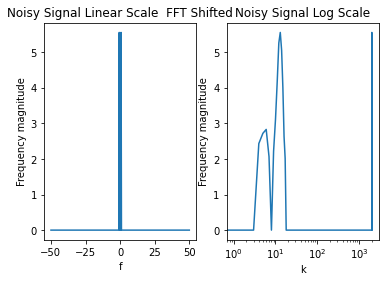

In [17]:
# Look at frequencies again
f_hat = np.fft.fft(f,n=length_sig, norm="ortho")



plt.subplot(1, 2, 1)
plt.title("Noisy Signal Linear Scale  FFT Shifted")
plt.ylabel("Frequency magnitude")
plt.xlabel("f")
plt.plot(fs_shifted,np.abs(np.fft.fftshift(f_hat)))
plt.subplot(1, 2, 2)
plt.title("Noisy Signal Log Scale")
plt.xscale('log')
plt.ylabel("Frequency magnitude")
plt.xlabel("k")
plt.plot(k,np.abs(f_hat))
plt.show()


# Set threshold for peaks

height = 2
f_hat_peaks = f_hat
f_hat_peaks[np.abs(f_hat_peaks)<height] = 0

plt.subplot(1, 2, 1)
plt.title("Noisy Signal Linear Scale  FFT Shifted")
plt.ylabel("Frequency magnitude")
plt.xlabel("f")
plt.plot(fs_shifted,np.abs(np.fft.fftshift(f_hat_peaks)))
plt.subplot(1, 2, 2)
plt.title("Noisy Signal Log Scale")
plt.xscale('log')
plt.ylabel("Frequency magnitude")
plt.xlabel("k")
plt.plot(k,np.abs(f_hat_peaks))
plt.show()



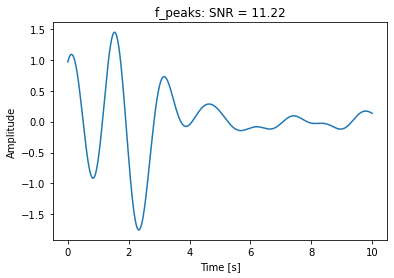

In [18]:
# Look in signal space
f_peaks = np.fft.ifft(f_hat_peaks, norm="ortho")
f_peaks = np.real(f_peaks)

P_noisefrom_peaks = np.linalg.norm(s - f_peaks[0:N])

SNR_peaks = 10*np.log(P_s/P_noisefrom_peaks)

# Back to time
f_filtered = np.fft.ifft(f_hat_filtered)
plt.title("f_peaks: SNR = %2.2f" %SNR_peaks)
plt.ylabel("Amplitude")
plt.xlabel("Time [s]")
plt.plot(t, f_peaks[0:N])
plt.show()